# Imports

In [ ]:
import sys
import matplotlib.pyplot as plt

In [ ]:
# sys.path.insert(1, '/kaggle/input/utiletet')
# from util import *

# Load the data

In [2]:
df = pd.read_csv('Dataset/final_data.csv')

# Creating dataset and Training

In order to avoid bias results because of randomness, we will use the train_evaluate_repeat function from utils to train the model on multiple datasets and report the average results.

We will also make a huge test set to cover most of the combinations.

In [ ]:
target_col_name = 'value_eur'

In [ ]:
test_pairs = generate_random_pairs(df, 20000)
test_df = create_pair_df(df, test_pairs, target_col_name)

In [5]:
tree_depth = int(np.round(np.sqrt(len(df.columns))))

In [ ]:
mf1 = train_evaluate_repeat(generate_random_pairs, data, num_samples=10000, depth=tree_depth, test_df=test_df, use_bradley=True, add_noise=False, noise=0.1, label_col=target_col_name, repeats=5)

100%|██████████| 100/100 [00:44<00:00,  2.25it/s]

Mean Accuracy: 0.9246415
Mean Precision: 0.9169021087271843
Mean Recall: 0.931992096463674
Mean F1 Score: 0.92427440937402


We can see that although we used pca to put the labels, the accuracy is great. Now this model is ready to be used as a pretrained model.

Now we check the variance of the dataset according to the PCA and determine the number of pretraining samples according to this factor.

In [6]:
var, residuals = calculate_pca_var(df, target_col)
print(var)

193649924457750.22


In [7]:
# Calculating the number of pairs
max_pairs = len(df) * 100
alpha = 1e-12

num_pairs = int(max_pairs / (1 + alpha * var))
print(num_pairs)

8230


In [8]:
df.reset_index(inplace=True, drop=True)

Now we will do a comparison. We will pretrain a model on 5000 samples using the PCA score and use it as a baseline for finetuning. Then we will prepare another model which is blank and is not trained at all. We will compare their accuracies on the test set while giving them actuall training samples to compare their performance. We will implement this step by step.

In [ ]:
pretrain_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': tree_depth
}
pretrained_model = pretrain_model_with_residuals(df=data, n_samples=num_pairs, pretrain_params=pretrain_params, target_col=target_col_name, residuals=residuals)

In [ ]:
step = 50
num_samples = 1000
repeats = 50

f1_scores_UB_repeats = []
f1_scores_UP_repeats = []
f1_scores_RB_repeats = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats.append(f1_scores_UB)
    f1_scores_UP_repeats.append(f1_scores_UP)
    f1_scores_RB_repeats.append(f1_scores_RB)

# Compute the average F1 scores across repeats
average_f1_scores_UB = np.mean(f1_scores_UB_repeats, axis=0)
average_f1_scores_UP = np.mean(f1_scores_UP_repeats, axis=0)
average_f1_scores_RB = np.mean(f1_scores_RB_repeats, axis=0)

Blank model with random pairs: 100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


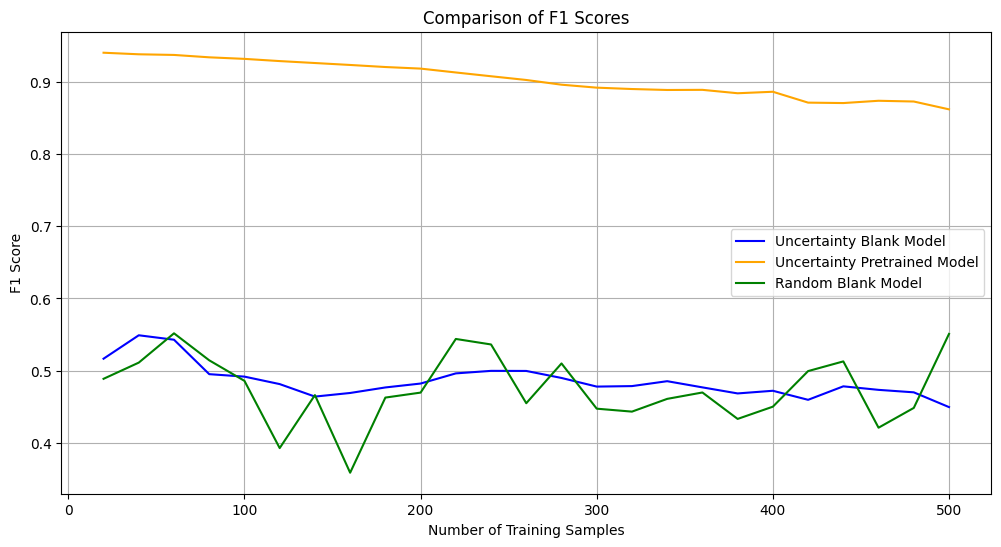

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Best Performance')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with huge repetition')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
step = 50
num_samples = 10000
repeats = 1

f1_scores_UB_repeats2 = []
f1_scores_UP_repeats2 = []
f1_scores_RB_repeats2 = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats2.append(f1_scores_UB)
    f1_scores_UP_repeats2.append(f1_scores_UP)
    f1_scores_RB_repeats2.append(f1_scores_RB)

# Compute the average F1 scores across repeats
average_f1_scores_UB2 = np.mean(f1_scores_UB_repeats2, axis=0)
average_f1_scores_UP2 = np.mean(f1_scores_UP_repeats2, axis=0)
average_f1_scores_RB2 = np.mean(f1_scores_RB_repeats2, axis=0)

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB2, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP2, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB2, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Best Performance')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with wide spectrum')
plt.legend()
plt.grid(True)
plt.show()